In [42]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
from lovely_tensors.patch import monkey_patch

monkey_patch()
import torch
from transformers import GPT2Tokenizer
import wandb
from tqdm import tqdm

import json
import os
from pathlib import Path

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [45]:
# from datasets import load_dataset

# dataset = load_dataset("roneneldan/TinyStories")

In [46]:
# Pre-process the tiny stories dataset

# TS_PATH = "./ts/"
# TS_PATH = Path(TS_PATH)


# gpt35_stories = []
# gpt4_stories = []

import unidecode

# for file in tqdm(list(sorted(os.listdir(TS_PATH)))):
#     if file.endswith(".json"):
#         with open(TS_PATH / file, "r") as f:
#             data = json.load(f)
#             for d in data:
#                 story = d["story"]
#                 if not all(ord(c) < 128 for c in story):
#                     story = unidecode.unidecode(story)

#                 if d["source"] == "GPT-3.5":
#                     gpt35_stories.append(story)
#                 elif d["source"] == "GPT-4":
#                     gpt4_stories.append(story)

# with open("gpt35_stories.txt", "w") as f:
#     f.write("\n".join(gpt35_stories))

# with open("gpt4_stories.txt", "w") as f:
#     f.write("\n".join(gpt4_stories))

with open("gpt35_stories.txt", "r") as f:
    gpt35_stories = f.readlines()

with open("gpt4_stories.txt", "r") as f:
    gpt4_stories = f.readlines()

In [47]:
# data = "\n".join(gpt35_stories + gpt4_stories)
data = "\n".join(gpt35_stories[:100_000])

del gpt35_stories
del gpt4_stories

In [48]:
chars = sorted(list(set(data)))

# create a mapping from characters to integers
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}


def encode(s):
    return [stoi[c] for c in s]  # encoder: take a string, output a list of integers


def decode(l):
    return "".join(
        [itos[i] for i in l]
    )  # decoder: take a list of integers, output a string

In [49]:
"".join(chars), len(chars)

('\n !"$\'()+,-.0123456789:?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz',
 76)

In [50]:
# encoded_data = encode(data)
train_data = data[: int(len(data)) - 200_000]
val_data = data[int(len(data)) - 200_000 :]
del data

# train_data = torch.tensor(data)
# val_data = torch.tensor(val_data)

In [51]:
def get_item(data, ctx):
    # i = random.randint(0, len(data) - ctx - 1)
    i = 0
    while i + ctx < len(data):
        src = data[i : i + ctx]
        dst = data[i + 1 : i + ctx + 1]
        yield torch.tensor(encode(src)), torch.tensor(encode(dst))
        i += ctx


def get_epoch(data, ctx_len, batch_size, shuffle=True):
    """Yields a tuple of tensors of shape (batch_size, ctx).
    X, shape=B C
    y, shape=B C
    """

    items = get_item(data, ctx_len)

    try:
        while True:
            X, y = zip(*[next(items) for _ in range(batch_size)])
            yield torch.stack(X), torch.stack(y)
    except StopIteration:
        pass

In [52]:
import random


def get_random_item(data, ctx):
    i = random.randint(0, len(data) - ctx - 1)

    src = data[i : i + ctx]
    dst = data[i + 1 : i + ctx + 1]

    return torch.tensor(encode(src)), torch.tensor(encode(dst))


def get_batch(data, ctx_len, batch_size, shuffle=True):
    """Yields a tuple of tensors of shape (batch_size, ctx).
    X, shape=B C
    y, shape=B C
    """

    batch = [get_random_item(data, ctx_len) for _ in range(batch_size)]
    X, y = zip(*batch)

    return torch.stack(X), torch.stack(y)


get_batch(train_data[:100], ctx_len=5, batch_size=2)

(tensor[2, 5] i64 n=10 x∈[1, 70] μ=48.200 σ=25.685 [[63, 52, 54, 1, 70], [67, 61, 1, 63, 50]],
 tensor[2, 5] i64 n=10 x∈[1, 70] μ=47.900 σ=25.467 [[52, 54, 1, 70, 65], [61, 1, 63, 50, 62]])

In [53]:
CTX_LEN = 12
EMBEDDING_DIM = 128
BATCH_SIZE = 4096

X, y = get_batch(train_data, ctx_len=CTX_LEN, batch_size=BATCH_SIZE, shuffle=True)
X = X.to(device)
y = y.to(device)

In [54]:
[1, 2, 3] + [4, 5, 6]

[1, 2, 3, 4, 5, 6]

In [86]:
import math

In [91]:
M = torch.zeros((128, EMBEDDING_DIM))
M


for pos in range(M.shape[0]):
    for i in range(M.shape[1] // 2):
        M[pos, 2 * i] = torch.sin(torch.tensor(pos / 10000 ** (i / M.shape[1])))
        M[pos, 2 * i + 1] = torch.cos(torch.tensor(pos / 10000 ** ((i) / M.shape[1])))

# M.chans(scale=10)

In [97]:
# def attention_block(params, input_ids, vocab_size):
import math


def make_params(embedding_dim, ctx_len, vocab_size, layers, device):
    model_params = {
        "embedding": torch.randn((vocab_size, embedding_dim), device=device),
        "pos_enc": torch.randn((embedding_dim, ctx_len), device=device),
        "blocks": [],
        "w_ln_f": torch.ones((embedding_dim), device=device),
        "b_ln_f": torch.zeros((embedding_dim,), device=device),
        "decoding": torch.rand((vocab_size, embedding_dim), device=device)
        / math.sqrt(vocab_size),
    }

    for _ in range(layers):
        block = {
            "w_ln1": torch.ones((embedding_dim), device=device),
            "b_ln1": torch.zeros((embedding_dim,), device=device),
            "w_attn_k": torch.randn((embedding_dim, embedding_dim), device=device),
            "w_attn_q": torch.randn((embedding_dim, embedding_dim), device=device),
            "w_attn_v": torch.randn((embedding_dim, embedding_dim), device=device),
            "w_fc_up": torch.randn((embedding_dim * 4, embedding_dim), device=device),
            "b_fc_up": torch.randn((embedding_dim * 4,), device=device),
            "w_fc_down": torch.randn((embedding_dim, embedding_dim * 4), device=device),
            "b_fc_down": torch.randn((embedding_dim,), device=device),
            "w_ln2": torch.ones((embedding_dim), device=device),
            "b_ln2": torch.zeros((embedding_dim,), device=device),
        }
        model_params["blocks"].append(block)

    return model_params


def init_params(params):
    M = params["pos_enc"]
    for pos in range(M.shape[0]):
        for i in range(M.shape[1] // 2):
            M[M.shape[0] - 1 - pos, 2 * i] = torch.sin(
                torch.tensor(pos / 10000 ** (i / M.shape[1]))
            )
            M[M.shape[0] - 1 - pos, 2 * i + 1] = torch.cos(
                torch.tensor(pos / 10000 ** ((i) / M.shape[1]))
            )


model_params = make_params(EMBEDDING_DIM, CTX_LEN, len(chars), 2, device)
init_params(model_params)


def transformer_block(params, hidden_states):
    res1 = hidden_states
    # print(f"{hidden_states=}")

    ln1 = torch.nn.functional.layer_norm(
        input=hidden_states,
        weight=params["w_ln1"],
        bias=params["w_ln1"],
        normalized_shape=(hidden_states.shape[-1],),
    )

    # print(f"{ln1=}")
    # print(f"{params['w_attn_k'].T=}")

    attn_k = ln1 @ params["w_attn_k"].T
    attn_q = ln1 @ params["w_attn_q"].T
    attn_v = ln1 @ params["w_attn_v"].T

    # print(f"{attn_k=}")
    # print(f"{attn_q=}")

    n_embed = hidden_states.shape[-1]
    attn = (attn_q @ attn_k.transpose(-1, -2)) / math.sqrt(n_embed)

    attn = torch.nn.functional.softmax(attn, dim=-1)

    out = attn @ attn_v + res1

    res2 = out

    ln2 = torch.nn.functional.layer_norm(
        input=out,
        weight=params["w_ln2"],
        bias=params["b_ln2"],
        normalized_shape=(hidden_states.shape[-1],),
    )

    fc_up = ln2 @ params["w_fc_up"].T + params["b_fc_up"]
    fc_up = torch.nn.functional.gelu(fc_up)

    fc_down = fc_up @ params["w_fc_down"].T + params["b_fc_down"]

    return fc_down + res2


def model(params, input_ids, vocab_size):
    input_ids = input_ids.long()

    embeddings = params["embedding"][input_ids]  # N, CTX_LEN, EMBEDDING_DIM
    pos_enc = params["pos_enc"].T[: input_ids.shape[1]]

    hidden_states = embeddings + pos_enc
    # print(embeddings)

    for block in params["blocks"]:
        hidden_states = transformer_block(block, hidden_states)

    ln_f = torch.nn.functional.layer_norm(
        input=hidden_states,
        weight=params["w_ln_f"],
        bias=params["b_ln_f"],
        normalized_shape=(hidden_states.shape[-1],),
    )

    return ln_f[:, -1, :] @ params["decoding"].T


res = model(model_params, X, len(chars))
res

tensor[4096, 76] n=311296 (1.2Mb) x∈[-1.531, 1.341] μ=-0.041 σ=0.388 cuda:0

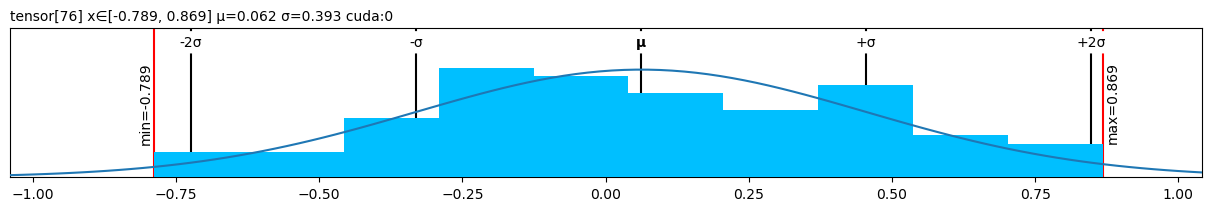

In [56]:
res[0].plt

In [57]:
torch.nn.functional.cross_entropy(res[0], torch.tensor(3).to(device))

tensor cuda:0 4.080

In [58]:
# res.softmax(-1).chans(scale=10)

In [59]:
def generate(
    model, model_params, ctx_len, encoded_prompt, n_tokens, temperature=0.0, top_k=1
):
    """Generate n_tokens after prompt"""
    with torch.no_grad():
        for _ in range(n_tokens):
            # print(encoded_prompt)
            preds = model(
                model_params, encoded_prompt[:, -ctx_len:], vocab_size=len(chars)
            )
            # print(f"{preds=}")

            # probs = torch.nn.functional.softmax(preds, dim=-1)
            # probs = probs.pow(1 / (temperature + 1e-6))

            if temperature == 0.0:
                next_token = torch.argmax(preds, dim=-1).unsqueeze(-1)
            else:
                log_probs = torch.nn.functional.log_softmax(preds, dim=-1)
                # print(f"{log_probs=}")
                log_probs = log_probs / (temperature + 1e-6)
                probs = torch.exp(log_probs)
                print(f"{probs=}")

                # Implementing top-k sampling
                top_k_probs, top_k_indices = torch.topk(probs, top_k)
                next_token = torch.multinomial(top_k_probs, num_samples=1)
                next_token = top_k_indices.gather(dim=1, index=next_token)

            # print(f"{next_token=}")

            encoded_prompt = torch.cat([encoded_prompt, next_token], dim=1)
    return encoded_prompt


generate(model, model_params, CTX_LEN, X[:5], 1, temperature=0.0, top_k=1)

tensor[5, 13] i64 n=65 x∈[0, 74] μ=45.185 σ=25.633 cuda:0

In [60]:
print(f"Length of the training data: {len(train_data):,}")

Length of the training data: 20,752,699


In [98]:
CTX_LEN = 12
EMBEDDING_DIM = 128


BATCH_SIZE = 4096
LR = 0.1

TRAIN_TOKENS = 1_000_000_000


LOG_INTERVAL = min(
    (min(TRAIN_TOKENS, len(train_data)) // (BATCH_SIZE * CTX_LEN) // 10) + 1, 1000
)
VALIDATION_INTERVAL = LOG_INTERVAL * 2


run = wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    entity="llmnerds",
    config={
        "batch_size": BATCH_SIZE,
        "ctx": CTX_LEN,
    },
)

model_params = make_params(EMBEDDING_DIM, CTX_LEN, len(chars), 2, device)
init_params(model_params)


def get_params(param_dict_or_list_or_tensor) -> list[torch.Tensor]:
    params = []
    if isinstance(param_dict_or_list_or_tensor, dict):
        for v in param_dict_or_list_or_tensor.values():
            params.extend(get_params(v))
    elif isinstance(param_dict_or_list_or_tensor, list):
        for v in param_dict_or_list_or_tensor:
            params.extend(get_params(v))
    else:  # If it's a tensor
        params.append(param_dict_or_list_or_tensor)
    return params


param_list = get_params(model_params)

for p in param_list:
    p.requires_grad = True

optim = torch.optim.Adam(param_list, lr=1e-3)

i = 1
total_loss = 0
val_total_loss = 0
token_count = 0


# batch_gen = get_batch(train_data, ctx_len=CTX_LEN, batch_size=BATCH_SIZE, shuffle=True)
with run:
    while token_count < TRAIN_TOKENS:
        X, y = get_batch(train_data, ctx_len=CTX_LEN, batch_size=BATCH_SIZE, shuffle=True)
        X = X.to(device)
        y = y.to(device)

        token_count = i * BATCH_SIZE * CTX_LEN

        preds = model(params=model_params, input_ids=X, vocab_size=len(chars))
        loss = torch.nn.functional.cross_entropy(input=preds, target=y[:, -1])
        total_loss += loss.item()
        loss.backward()

        with torch.no_grad():
            optim.step()
            optim.zero_grad()

            # for param in model_params.values():
            #     param -= LR * param.grad
            #     param.grad.zero_()

        if i % LOG_INTERVAL == 0:
            wandb.log(
                {
                    "loss": total_loss / LOG_INTERVAL,
                    "epoch": token_count // len(train_data),
                },
                step=token_count,
            )
            total_loss = 0

        if i % VALIDATION_INTERVAL == 0:
            j = 0
            for X_val, y_val in get_epoch(
                val_data, ctx_len=CTX_LEN, batch_size=4096, shuffle=False
            ):
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                with torch.no_grad():
                    preds = model(
                        params=model_params, input_ids=X_val, vocab_size=len(chars)
                    )
                    loss = torch.nn.functional.cross_entropy(preds, y_val[:, -1])
                    val_total_loss += loss.item()
                    j += 1
            wandb.log({"val_loss": val_total_loss / j}, step=token_count, commit=True)

            prompts = get_batch(val_data, ctx_len=CTX_LEN, batch_size=5)[0].to(device)
            generated = generate(
                model=model,
                model_params=model_params,
                encoded_prompt=prompts,
                ctx_len=CTX_LEN,
                n_tokens=CTX_LEN * 2,
            )
            for p in generated:
                char_list = p.tolist()
                pre_prompt = char_list[:CTX_LEN]
                post_prompt = char_list[CTX_LEN:]

                print(f"{repr(decode(pre_prompt))}-> {repr(decode(post_prompt))}")

            val_total_loss = 0
        i += 1

'nd helped he'-> ' and n he he t t an and '
's little bro'-> 't the he te the and n t '
'\n\nLily said,'-> '  t he te he he he he he'
' fell off hi'-> ' tthe te the and n t  he'
'me, there wa'-> 'n t  t he te he he he he'
' was so happ'-> 'andandt an the tan the a'
'a big, scary'-> ' wan the tan the and tan'
'o play outsi'-> 'd the tan the and tan an'
'he said to h'-> 'e tan and and tan the ta'
'ttery. It wi'-> '\nut the  to and and tan '
". You're a g"-> 'e the the wand the the t'
'ying with he'-> ' the and wand the the th'
' see the big'-> 'e the the wand the the t'
'eetie told t'-> 'he the the wand the the '
'eat it, so h'-> 'e the the wand the the t'
'o home and p'-> 'indang the the the the t'
'e loved to p'-> 'ly and the the the the t'
'ok nice."\n\nL'-> ' ly and the the the the '
'y continued '-> 'the Lit the the the the '
's. The firew'-> ' he the the the the the '
'k." The litt'-> 'ly wan to to tor to to t'
'o anything b'-> 'e and a lit the to to" t'
'girl named L'-> 'ily wan a

Traceback (most recent call last):
  File "/tmp/ipykernel_23856/2780676932.py", line 60, in <module>
    X, y = get_batch(train_data, ctx_len=CTX_LEN, batch_size=BATCH_SIZE, shuffle=True)
  File "/tmp/ipykernel_23856/3277373966.py", line 19, in get_batch
    batch = [get_random_item(data, ctx_len) for _ in range(batch_size)]
  File "/tmp/ipykernel_23856/3277373966.py", line 19, in <listcomp>
    batch = [get_random_item(data, ctx_len) for _ in range(batch_size)]
  File "/tmp/ipykernel_23856/3277373966.py", line 10, in get_random_item
    return torch.tensor(encode(src)), torch.tensor(encode(dst))
KeyboardInterrupt


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▄▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▃▂▂▂▂▁▁▁▂▁▁▁
val_loss,█▅▄▄▃▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▃▂▂▁▂▁▁▁▁▁▁▁
epoch,32
loss,1.34596
val_loss,1.36791


KeyboardInterrupt: 

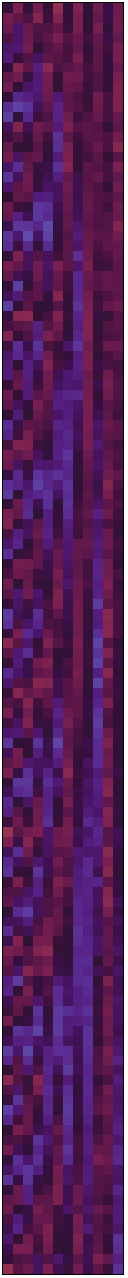

In [95]:
model_params["pos_enc"].div(4).chans(scale=10)

In [40]:
torch.cuda.empty_cache()

In [41]:
prompts = get_batch(val_data, ctx_len=CTX_LEN, batch_size=5)[0].to(device)

In [86]:
generated = generate(
    model=model,
    model_params=model_params,
    encoded_prompt=prompts,
    ctx_len=CTX_LEN,
    n_tokens=300,
    temperature=1,
    top_k=50,
)
for p in generated:
    char_list = p.tolist()
    pre_prompt = char_list[:CTX_LEN]
    post_prompt = char_list[CTX_LEN:]

    print(f"{repr(decode(pre_prompt))}-> {repr(decode(post_prompt))}")

'er! \nThe nex'-> "t day, Mian's mommy was excited the juice. They always. One day, who had a special bying. They had lottle joge again. The smy loved the boy came. After to the hole around again.\nOnce upon a time, heavy, Timmy saw tight. A fincy only the world and lishes. She knew it to all her longerded to open the "
'yons and sta'-> 'y of a happy\'s toys asked toys to their can. From that day on, every dog! The cat was very sad. Her mom said, happy tow excited for a wards selfush an inside to be needet. Lily went to help other look promise toy cursy for is.\nOne day, she would little crreful, "We ble crying. They saw that the pine'
'hing unexpec'-> 'ted. It is tho lottle boy. He was excited to see wear appined to see Pally learn and went to the pandow. This yag cats. She glapped her laughed. She wolded Sue. Sue said, "No, so not having to marccold not started Tom and his differents the speeper- and they all their stickets and them a pudding on '
'ded to keep '-> 'behieset and nover

In [ ]:
import json

d = json.load(open("tmp/data00.json", "r"))

In [46]:
def get_params(u) -> list[torch.Tensor]:  # u: param_dict_or_list_or_tensor
    flatten = lambda x: [item for sublist in x for item in sublist]
    return (
        flatten(u.values())
        if isinstance(u, dict)
        else flatten(u)
        if isinstance(u, list)
        else [u]
    )


param_list = get_params(model_params)

In [47]:
param_list

[tensor[128] x∈[-2.123, 2.940] μ=-0.047 σ=1.024 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.712, 2.628] μ=-0.039 σ=1.006 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.249, 2.290] μ=-0.032 σ=0.969 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.941, 2.137] μ=-0.017 σ=0.951 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.924, 3.264] μ=0.044 σ=1.083 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.790, 1.974] μ=0.044 σ=1.073 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.425, 2.174] μ=0.008 σ=0.819 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.192, 2.293] μ=0.026 σ=0.961 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.331, 3.046] μ=0.056 σ=0.947 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.999, 2.812] μ=-0.030 σ=1.109 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.824, 2.423] μ=-0.045 σ=0.981 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.368, 2.735] μ=-0.104 σ=0.840 grad UnbindBackward0 cuda:0,
 tensor[128] x∈[-2.499, 2.802] μ=0.011 σ=1.023 grad UnbindBackward0 cuda:0,
 tens